<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/Time_Series_forecasting_with_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Addopted from:
https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet-yt/notebook

and

https://youtu.be/j0eioK5edqg

read:
https://adamnovotny.com/blog/berkeley-global-temperature-forecast-prophet.html

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
pjme = pd.read_csv('https://raw.githubusercontent.com/archd3sai/Hourly-Energy-Consumption-Prediction/master/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


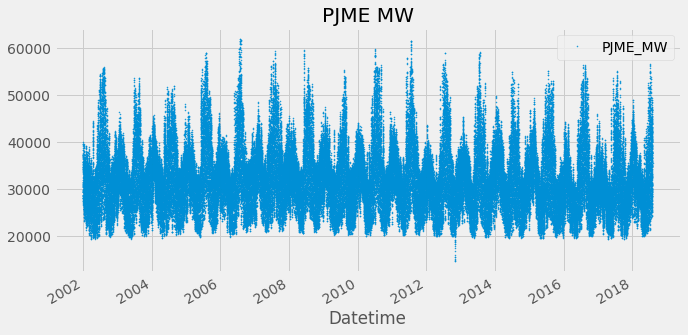

In [4]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

In [5]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

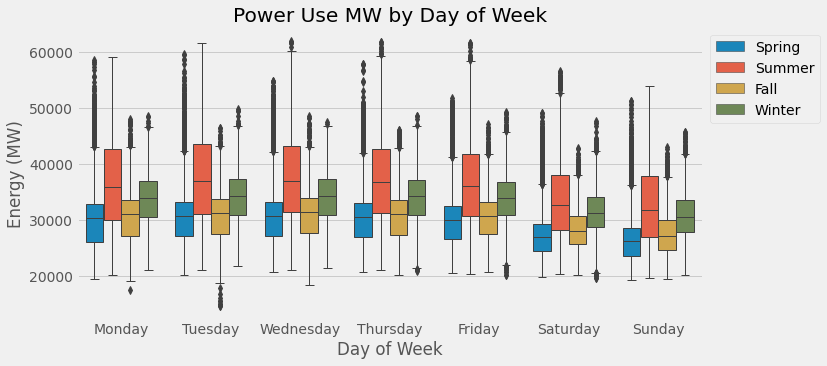

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

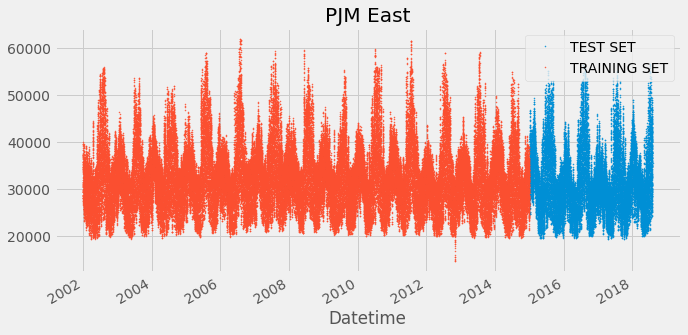

In [7]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

#Simple Prophet Model

In [8]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [9]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6xv79kx/i1jit1ou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6xv79kx/j84uv64r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75351', 'data', 'file=/tmp/tmpi6xv79kx/i1jit1ou.json', 'init=/tmp/tmpi6xv79kx/j84uv64r.json', 'output', 'file=/tmp/tmpi6xv79kx/prophet_modelwsdfeway/prophet_model-20221201090752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:07:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:11:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 17.1 s, sys: 1.18 s, total: 18.3 s
Wall time: 3min 49s


In [10]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [11]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.697022,23847.906898,32548.743480,31210.697022,31210.697022,-2862.203082,-2862.203082,-2862.203082,-4430.342550,...,1281.401225,1281.401225,1281.401225,286.738243,286.738243,286.738243,0.0,0.0,0.0,28348.493940
1,2015-01-01 02:00:00,31210.659947,22439.493622,31223.110221,31210.659947,31210.659947,-4366.556573,-4366.556573,-4366.556573,-5927.229009,...,1272.643174,1272.643174,1272.643174,288.029261,288.029261,288.029261,0.0,0.0,0.0,26844.103373
2,2015-01-01 03:00:00,31210.622871,21783.994668,30184.651634,31210.622871,31210.622871,-5238.271879,-5238.271879,-5238.271879,-6790.313052,...,1262.679362,1262.679362,1262.679362,289.361810,289.361810,289.361810,0.0,0.0,0.0,25972.350992
3,2015-01-01 04:00:00,31210.585796,21274.740418,30388.346981,31210.585796,31210.585796,-5379.878306,-5379.878306,-5379.878306,-6922.247590,...,1251.633368,1251.633368,1251.633368,290.735916,290.735916,290.735916,0.0,0.0,0.0,25830.707490
4,2015-01-01 05:00:00,31210.548721,22184.091030,31098.923153,31210.548721,31210.548721,-4705.597210,-4705.597210,-4705.597210,-6237.389790,...,1239.640977,1239.640977,1239.640977,292.151603,292.151603,292.151603,0.0,0.0,0.0,26504.951510


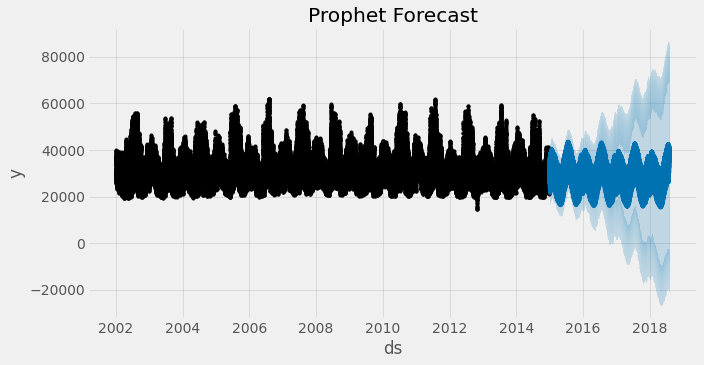

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

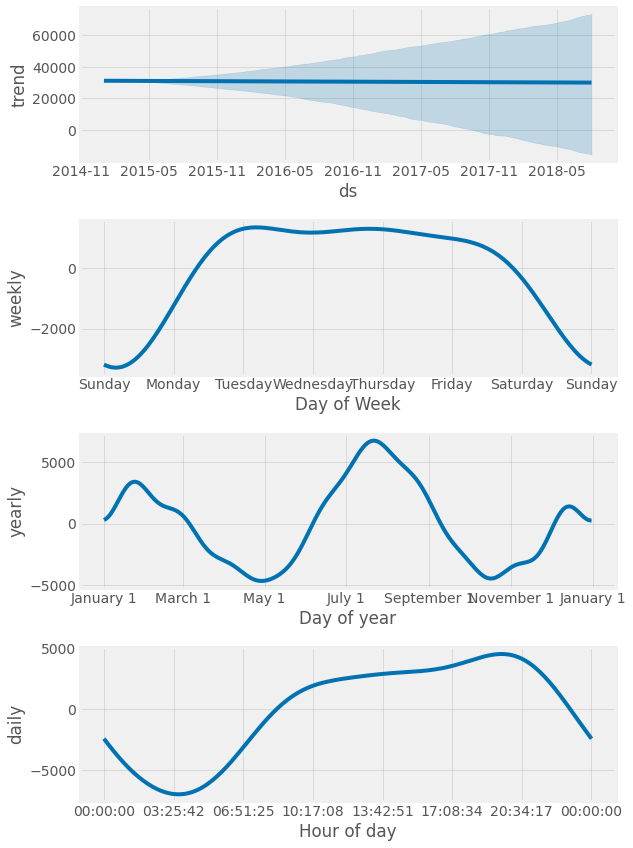

In [13]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

#Compare Forecast to Actuals

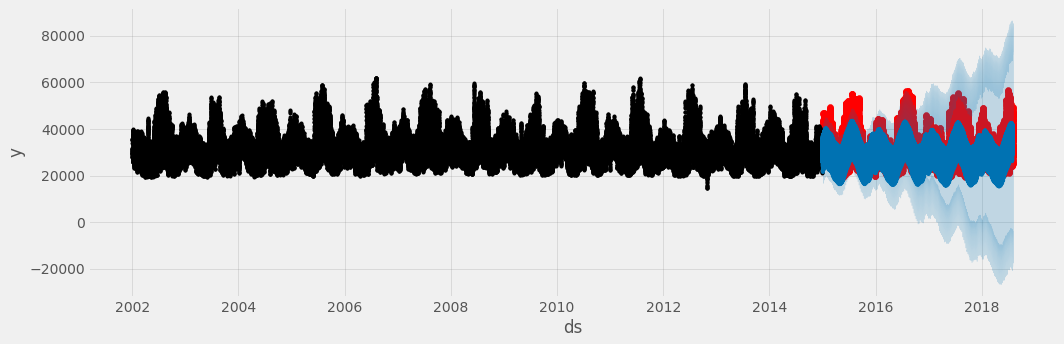

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

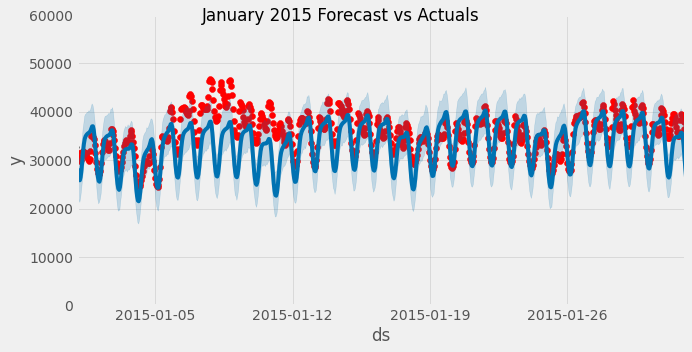

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015',
              upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

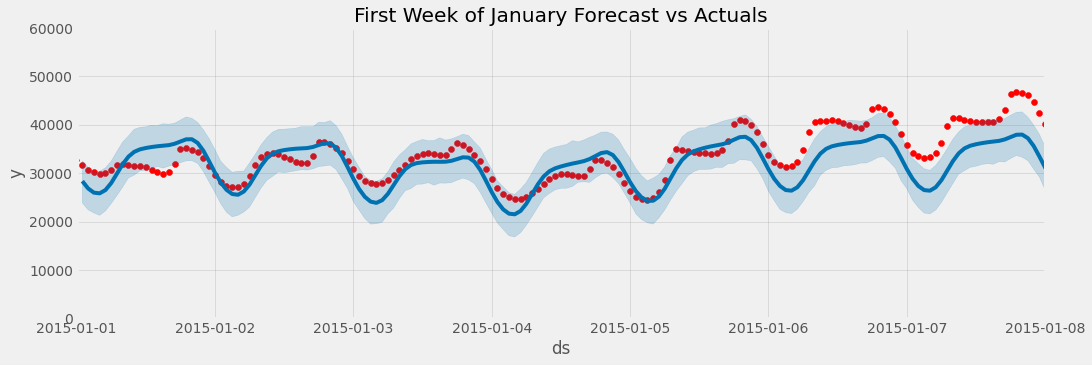

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

#Evaluate the model with Error Metrics

In [17]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6616.737540515163

In [18]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5182.267565102461

In [19]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.511400694540225

In [20]:
from sklearn.metrics import r2_score
rez=r2_score(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])
rez

-0.05243526380215746

#Adding Holidays

In [21]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [22]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6xv79kx/4qrj2wp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6xv79kx/k9y1vuv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5247', 'data', 'file=/tmp/tmpi6xv79kx/4qrj2wp9.json', 'init=/tmp/tmpi6xv79kx/k9y1vuv0.json', 'output', 'file=/tmp/tmpi6xv79kx/prophet_model459r2ui2/prophet_model-20221201093929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:39:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:42:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 12.7 s, sys: 1.42 s, total: 14.2 s
Wall time: 3min 22s


In [23]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

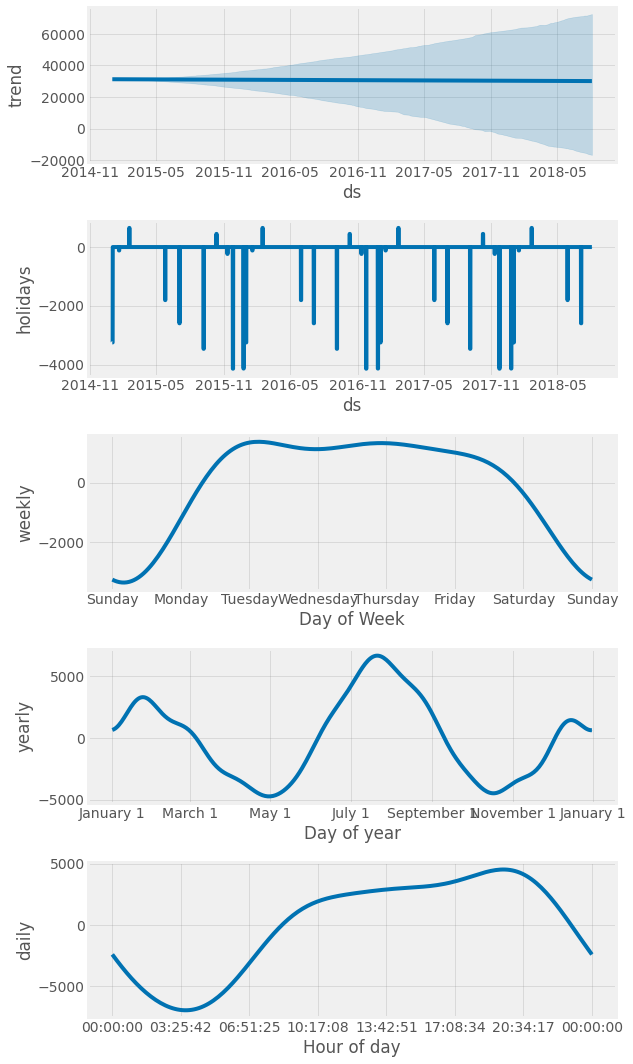

In [24]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

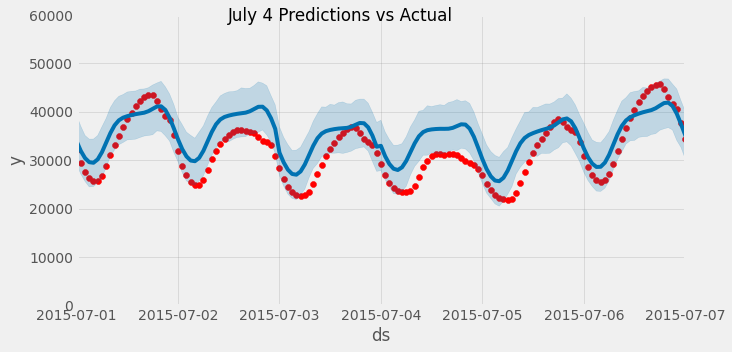

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015',
              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [26]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6635.083544673247

In [27]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5199.034389553907

In [28]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.56797632338498

#Predict into the Future

In [35]:
future = model.make_future_dataframe(periods=10*365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [30]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25552.130866
1,2015-01-01 02:00:00,24050.213498
2,2015-01-01 03:00:00,23180.680075
3,2015-01-01 04:00:00,23041.028545
4,2015-01-01 05:00:00,23716.963720


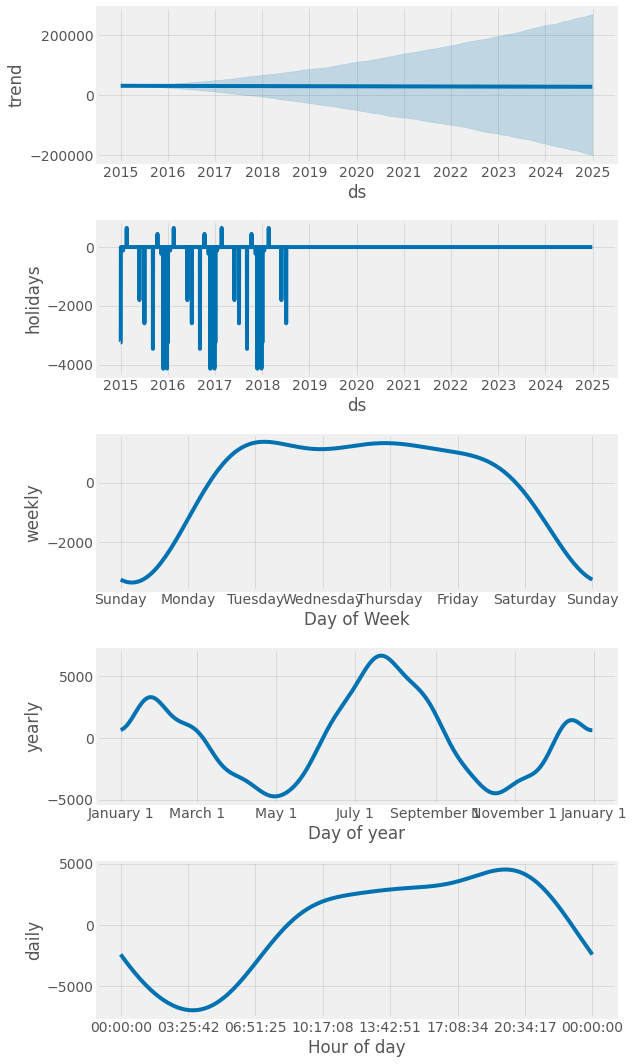

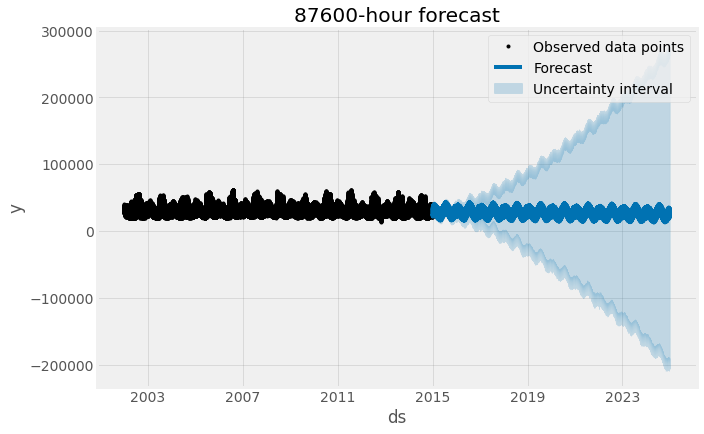

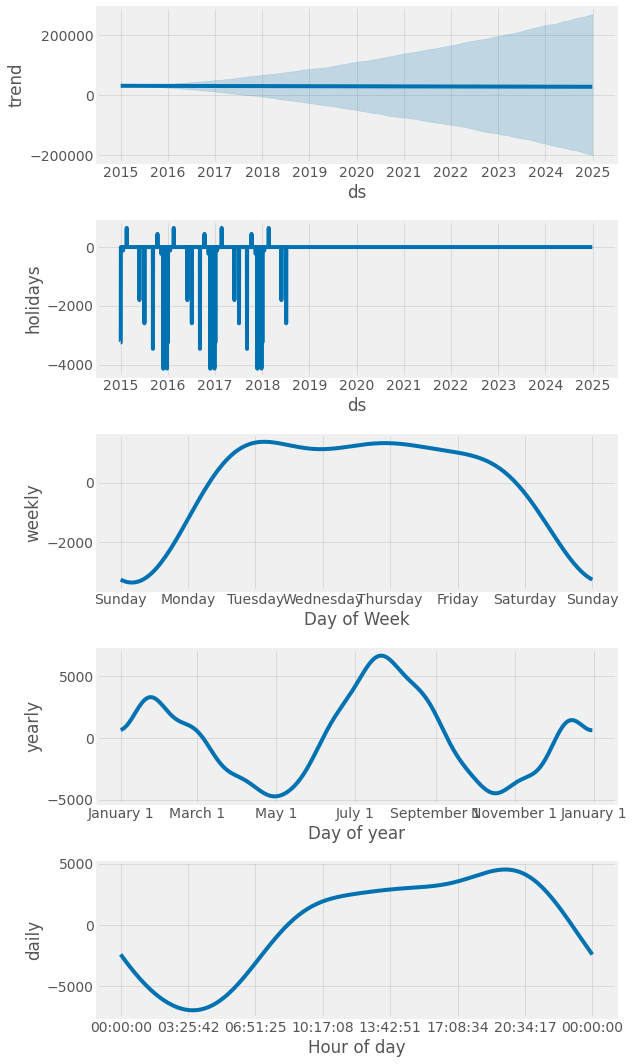

In [36]:
    # Plot the model and forecast
    model_with_holidays.plot(forecast, uncertainty=True)
    plt.title('{}-hour forecast'.format(10*365*24))
    plt.legend();
    
    # Plot the model components
    model_with_holidays.plot_components(forecast)